# Concept

*Problem:* 

1. I want to cluster my observations, but I have mainly categorical data. 


*Solution:*

1. Determine why you want to cluster. E.g. I want to group similar cars together for an auction. That means they should not have only similar price range but also be suitable for a similar goal.

2. Create a model that predicts the value of the car

3. Use the Shapley values for each car as metrics to cluster.

4. The key is to group the shapley value for each dummified together. E.g. dummy "Jaguar" and "Ferrari" values all go to the same column now. Now you have again cars that have gotten higher/lower prices because of their brand in that situation!


*Data source:* https://archive.ics.uci.edu/ml/datasets/Automobile

In [51]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [52]:
df = pd.read_csv('./data/auto_clean.csv')
df = df.dropna()
dummy_df = pd.get_dummies(df)
y = df['price']
X = dummy_df.drop('price',axis=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.5,test_size=0.5)

In [54]:
clf = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)

In [55]:
clf.score(X_train,y_train)

0.9872192031739951

In [56]:
clf.score(X_test,y_test)

0.873622573608573

# Shap

In [57]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [58]:


explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [48]:
shap.force_plot(explainer.expected_value, shap_values, X)

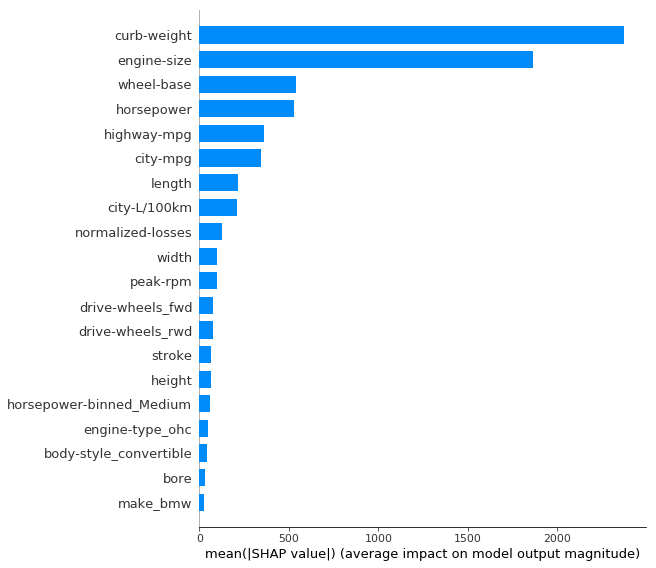

In [59]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [60]:
shap_test = pd.DataFrame(data=shap_values, index=X_test.index, columns=X_test.columns)

# Aggregate shaps for categoricals

In [63]:
categoricals = df.select_dtypes(['object']).columns
def aggregate_dummies(shap_df, categoricals):
    df = shap_df.copy()
    for cat in categoricals:
        dum_cols = [c for c in df.columns if c.startswith(cat)]
        df[cat] = df[dum_cols].sum(1)
        df = df.drop(dum_cols,axis=1)
    return df


agg_shap_test = aggregate_dummies(shap_test,categoricals)

In [74]:
agg_shap_test[categoricals].abs().mean().sort_values(ascending=False)

drive-wheels         147.559396
horsepower-binned     60.937362
body-style            54.719258
engine-type           51.692878
make                  37.336350
fuel-system           24.121003
aspiration            23.528617
num-of-doors           7.015048
engine-location        6.484721
num-of-cylinders       4.683479
dtype: float64

**Hey look! Number of doors & drive wheels are now more important!**

In [67]:
import matplotlib.pyplot as plt

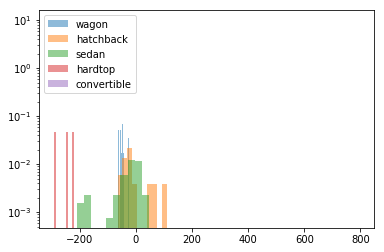

In [88]:
c = 'body-style'

foo = pd.DataFrame({c: df.loc[X_test.index,c], 
                    'shap': agg_shap_test[c]})

for v in foo[c].unique():
    if v != 'bmw':
        plt.hist(foo.loc[foo[c] == v,'shap'],alpha=0.5,label=v,density=True)
plt.legend()
plt.yscale('log')

**Hey look! We can see how some sedans get predicted a higher price because of their membership in the category while others are getting a lower predicted price**

# Clustering

**Next step:** Apply clustering to these grouped shapley values such that we can say stuff like:

These cars are similar because they are predicted to sell for a medium price as they are all of a good make, but with a bad body-style.

That's useful because if it turns out that this is a large group then they can make a strategy for that group.